*   `Customer ID`: A unique ID that identifies each customer.

Demographic info about customers:

*   `gender`: Whether the customer is a male or a female

*   `SeniorCitizen`: Whether the customer is a senior citizen or not (1, 0)

*   `Partner`: Whether the customer has a partner or not (Yes, No)

*   `Dependents`: Whether the customer has dependents or not (Yes, No)

Services that each customer has signed up for:

*   `PhoneService`: Whether the customer has a phone service or not (Yes, No)

*   `MultipleLines`: Whether the customer has multiple lines or not (Yes, No, No phone service)

*   `InternetService`: Customer’s internet service provider (DSL, Fiber optic, No)

*   `OnlineSecurity`: Whether the customer has online security or not (Yes, No, No internet service)

*  ` OnlineBackup`: Whether the customer has online backup or not (Yes, No, No internet service)

*   `DeviceProtection`: Whether the customer has device protection or not (Yes, No, No internet service)

*   `TechSupport`: Whether the customer has tech support or not (Yes, No, No internet service)

*   `StreamingTV`: Whether the customer has streaming TV or not (Yes, No, No internet service)

*   `StreamingMovies`: Whether the customer has streaming movies or not (Yes, No, No internet service)

Customer account information:

*   `tenure`: Number of months the customer has stayed with the company

*   `Contract`: The contract term of the customer (Month-to-month, One year, Two year)

*   `PaperlessBilling`: Whether the customer has paperless billing or not (Yes, No)

*   `PaymentMethod`: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

*   `MonthlyCharges`: The amount charged to the customer monthly

*   `TotalCharges`: The total amount charged to the customer

*   **`Churn`**: Target, Whether the customer has left within the last month or not (Yes or No)

##Import_Libraries_and_Data


In [1]:
# handle table-like data and matrices
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

# balance data
from imblearn.over_sampling import BorderlineSMOTE

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
#from mlens.ensemble import SuperLearner
from sklearn.neural_network import MLPClassifier

# evaluations
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# to display the total number columns present in the dataset
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('C:/Users/HP/OneDrive/Desktop/endtoendMLProject/capstone/train (1).csv')

##Handling_Missing_Values

let's find if we have missing values in the dataset. 

In [3]:
data = data.replace(r'^\s*$', np.nan, regex=True)

In [4]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

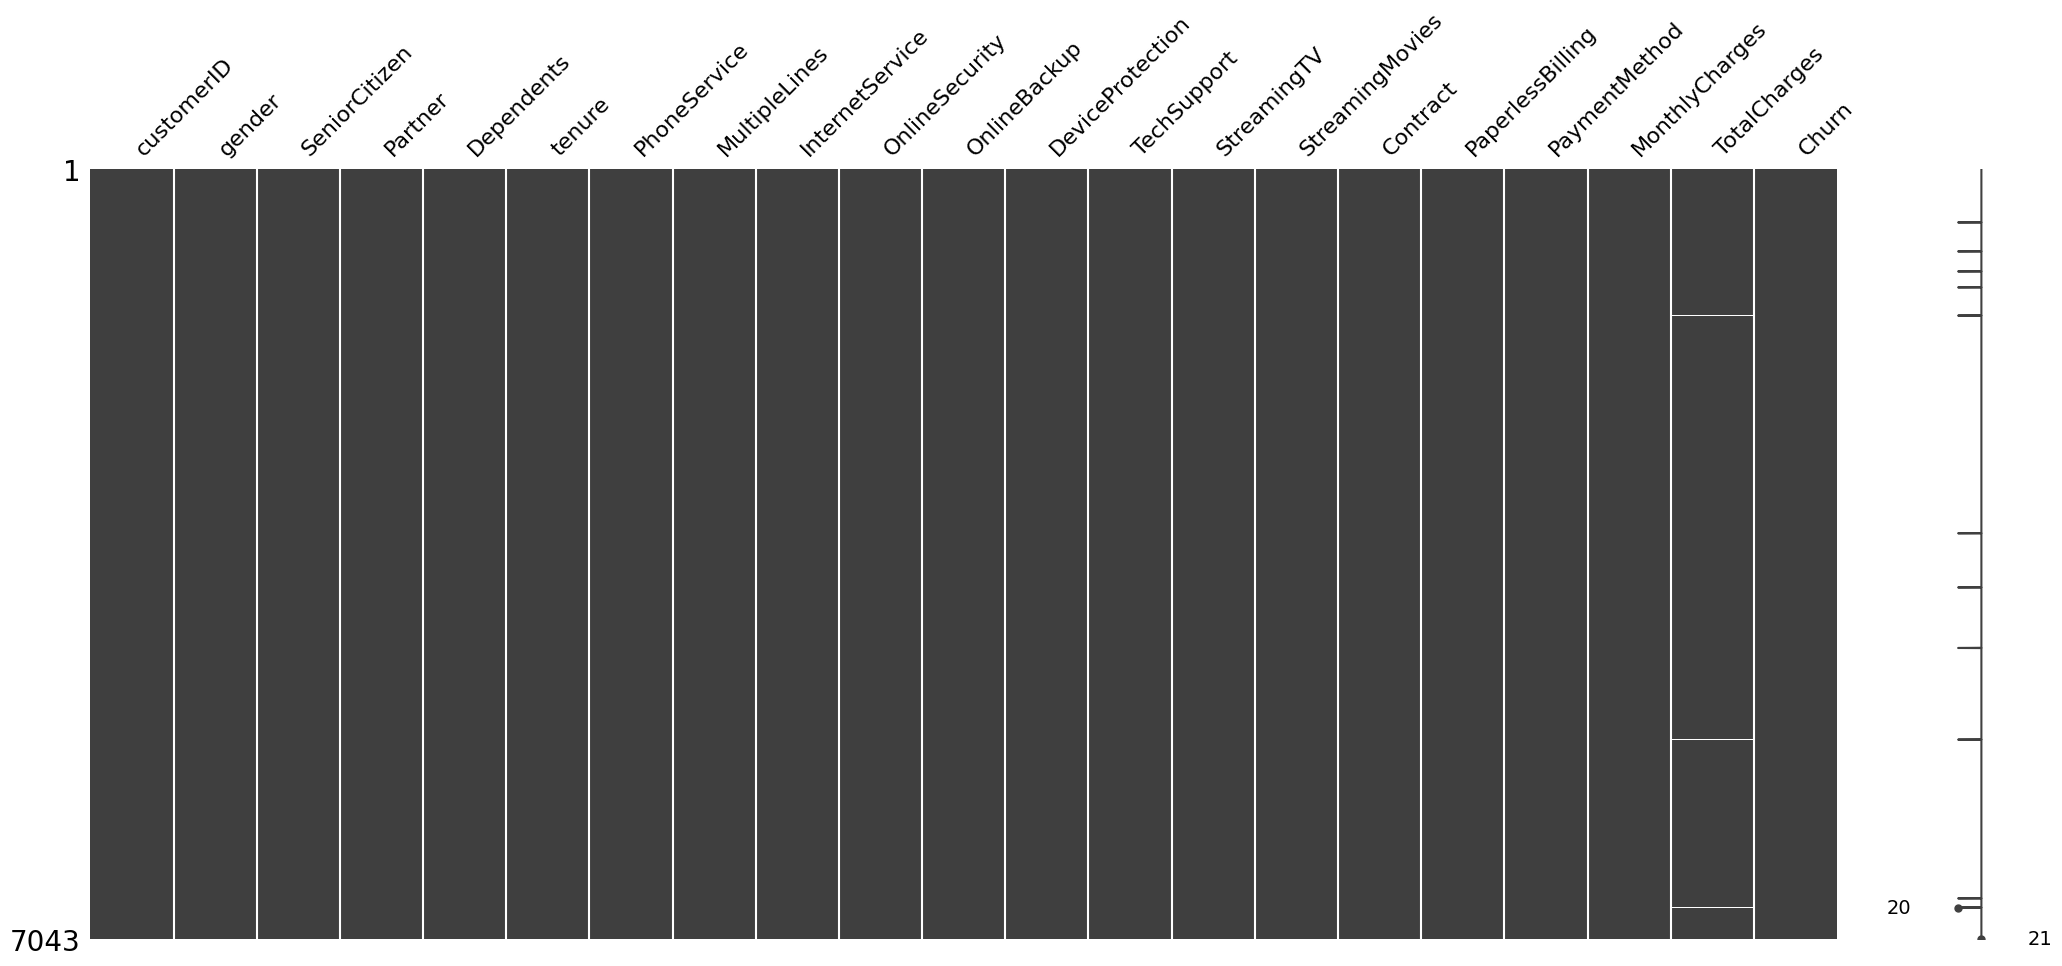

In [5]:
msno.matrix(data);

If we examine the data carefully, we can actually estimate the value of the missing data. 

Contract length in month * tenure (if not 0) * monthly charges

This is more accurate than filling missing values with mean or median.

In [6]:
data[data['TotalCharges'].isnull()].index.tolist()

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

In [7]:
ind = data[data['TotalCharges'].isnull()].index.tolist()
for i in ind:
  if data['Contract'].iloc[i,] == 'Two year':
    data['TotalCharges'].iloc[i,] = int(np.maximum(data['tenure'].iloc[i,], 1)) * data['MonthlyCharges'].iloc[i,] * 24
  elif data['Contract'].iloc[i,] == 'One year':
    data['TotalCharges'].iloc[i,] = int(np.maximum(data['tenure'].iloc[i,], 1)) * data['MonthlyCharges'].iloc[i,] * 12
  else:
    data['TotalCharges'].iloc[i,] = int(np.maximum(data['tenure'].iloc[i,], 1)) * data['MonthlyCharges'].iloc[i,]

In [8]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

let's find if we have duplicate rows.

In [9]:
data.duplicated().sum()

0

Data_Analysis_and_Visualization

In [10]:
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [11]:
data.shape

(7043, 21)

There are 7043 cutomers and 21 features in the dataset.

In [12]:
for i in data.columns[6:-3]:
  print(f'Number of categories in the variable {i}: {len(data[i].unique())}')

Number of categories in the variable PhoneService: 2
Number of categories in the variable MultipleLines: 3
Number of categories in the variable InternetService: 3
Number of categories in the variable OnlineSecurity: 3
Number of categories in the variable OnlineBackup: 3
Number of categories in the variable DeviceProtection: 3
Number of categories in the variable TechSupport: 3
Number of categories in the variable StreamingTV: 3
Number of categories in the variable StreamingMovies: 3
Number of categories in the variable Contract: 3
Number of categories in the variable PaperlessBilling: 2
Number of categories in the variable PaymentMethod: 4


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [14]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [15]:
data.describe(include=object).T

,count,unique,top,freq
customerID,7043,7043,7590-VHVEG,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


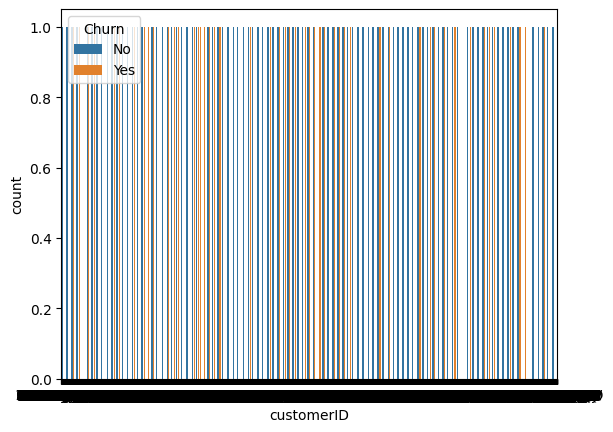

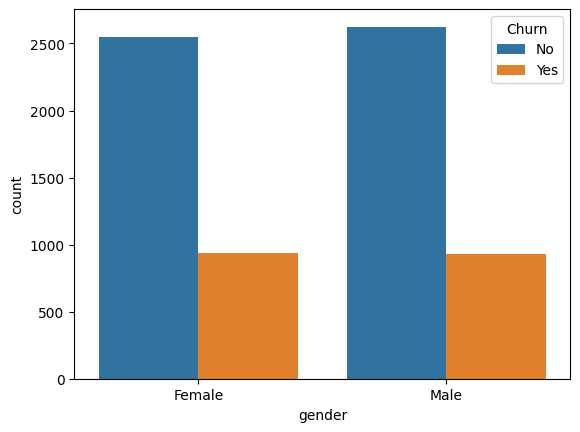

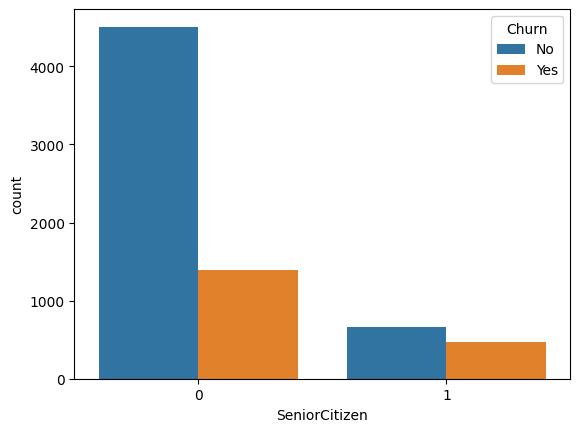

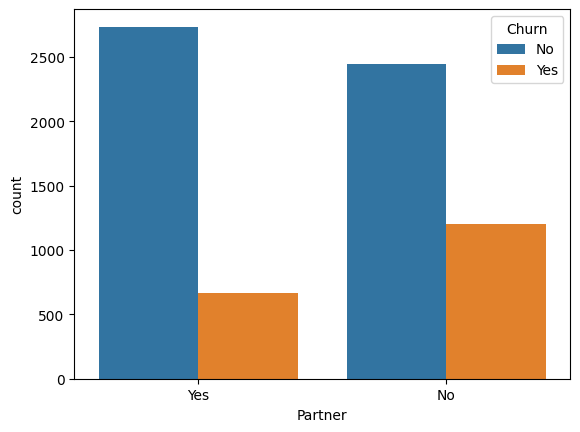

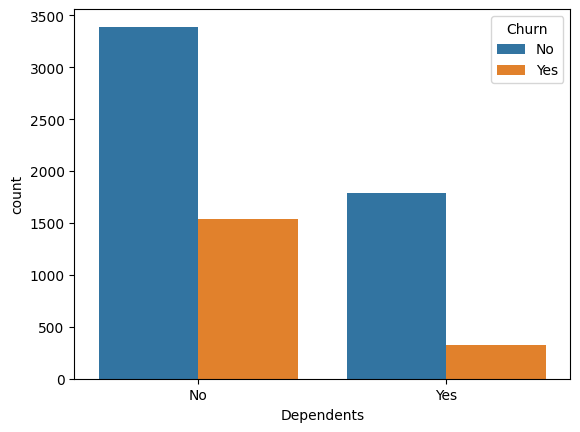

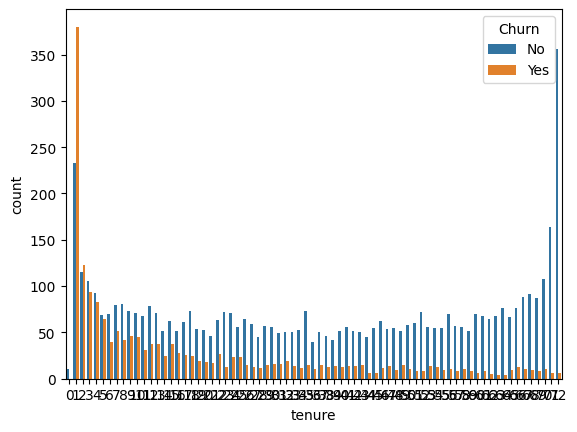

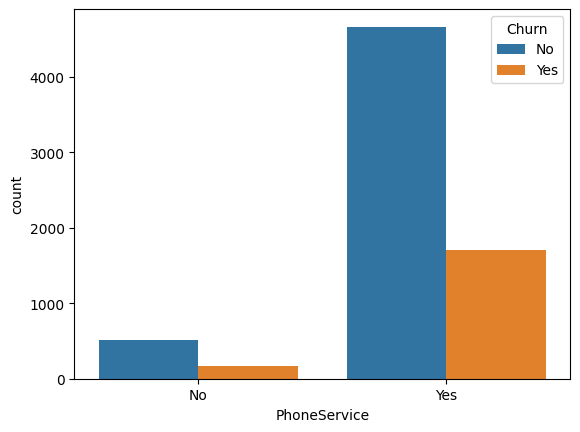

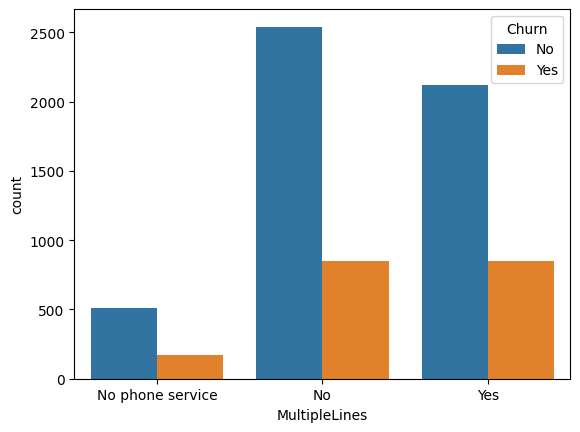

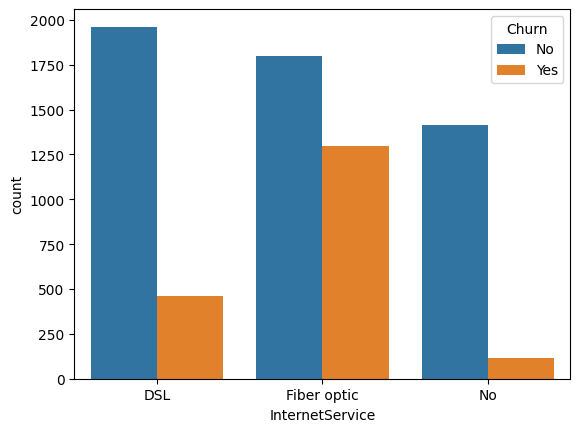

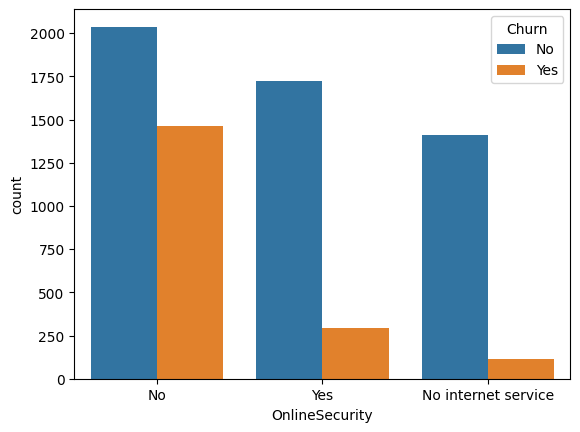

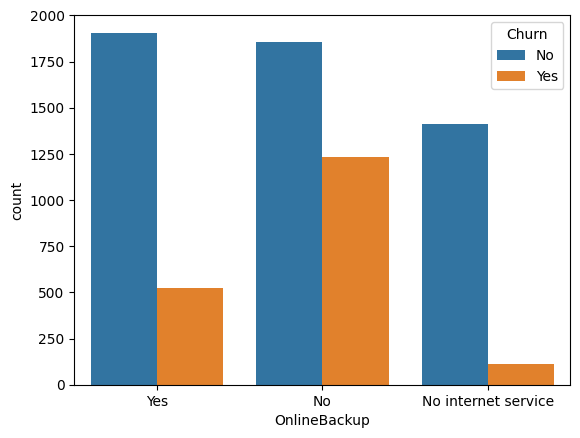

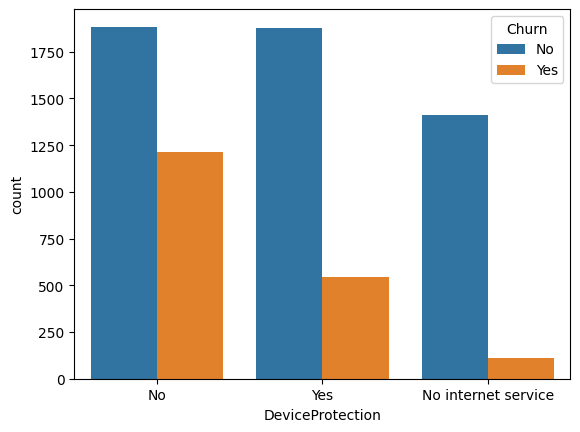

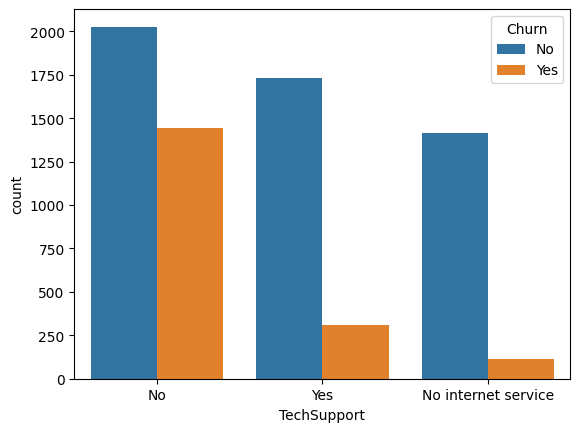

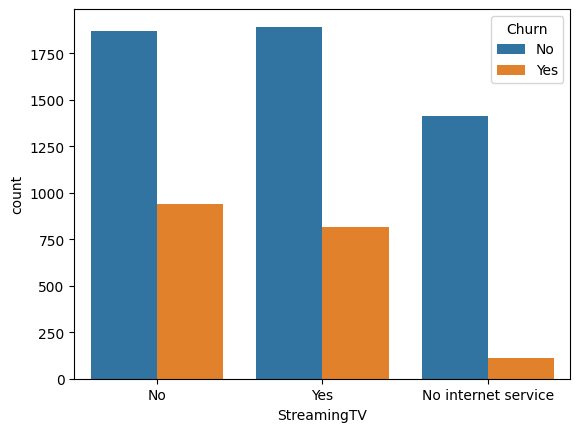

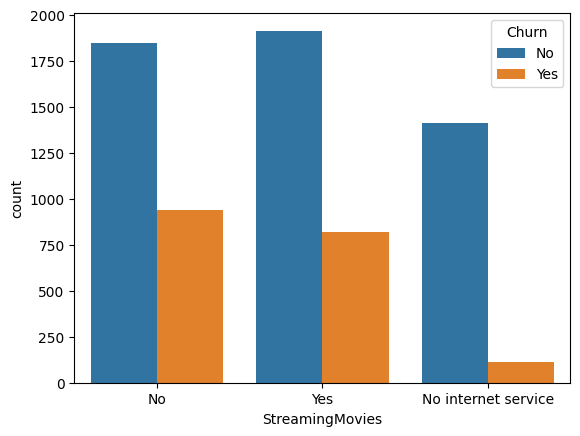

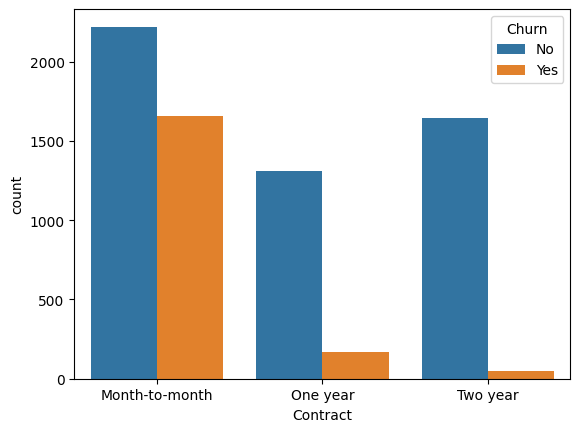

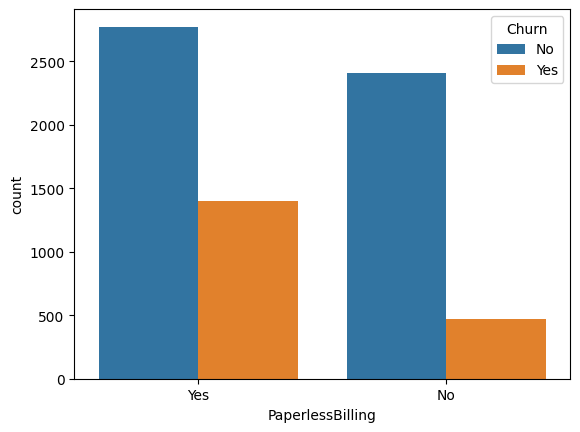

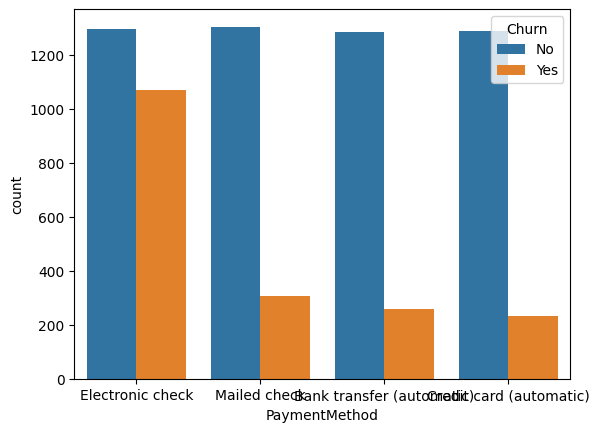

In [16]:
#Univariate Analysis
for i, predictor in enumerate(data.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])):
    plt.figure(i)
    sns.countplot(data=data, x=predictor, hue='Churn')

* We have imbalanced data.

* $26.6 \%$ of customers switched to another company.

* Customers are $49.5 \%$ female and $50.5 \%$ male.

In [17]:
print(f'A female customer has a probability of {round(data[(data["gender"] == "Female") & (data["Churn"] == "Yes")].count()[0] / data[(data["gender"] == "Female")].count()[0] *100,2)} % churn')

print(f'A male customer has a probability of {round(data[(data["gender"] == "Male") & (data["Churn"] == "Yes")].count()[0] / data[(data["gender"] == "Male")].count()[0]*100,2)} % churn')

A female customer has a probability of 26.92 % churn
A male customer has a probability of 26.16 % churn


* There is negligible difference in customer percentage who changed the service provider. Both genders behaved in similar way when it comes to migrating to another service provider.

* About $43\%$ of customer with Month-to-Month Contract opted to move out as compared to $11\%$ of customrs with One Year Contract and $3\%$ with Two Year Contract. A major percent of people who left the comapny had Month-to-Month Contract. This is acutually logical since people who have long-term contract are more loyal to the company.

* Major customers who moved out had Electronic Check as Payment Method.

* Customers who chose Credit-Card automatic transfer or Bank Automatic Transfer and Mailed Check as Payment Method were less likely to move out.

In [18]:
data[data['gender']=='Male'][['InternetService', 'Churn']].value_counts()

InternetService  Churn
DSL              No       993
Fiber optic      No       910
No               No       722
Fiber optic      Yes      633
DSL              Yes      240
No               Yes       57
dtype: int64

In [19]:
data[data['gender']=='Female'][['InternetService', 'Churn']].value_counts()

InternetService  Churn
DSL              No       969
Fiber optic      No       889
No               No       691
Fiber optic      Yes      664
DSL              Yes      219
No               Yes       56
dtype: int64

* A lot of customers choose the Fiber optic service and it's also evident that the customers who use Fiber optic have high churn rate, this might suggest a dissatisfaction with this type of internet service.

* Customers having DSL service are majority in number and have less churn rate compared to Fibre optic service.

In [20]:
new_df1_target0=data.loc[data["Churn"]==0]
new_df1_target1=data.loc[data["Churn"]==1]

In [21]:
print(f'A customer with dependents has a probability of {round(data[(data["Dependents"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["Dependents"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without dependents has a probability of {round(data[(data["Dependents"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["Dependents"] == "No")].count()[0]*100,2)} % churn')

A customer with dependents has a probability of 15.45 % churn
A customer without dependents has a probability of 31.28 % churn


* Customers without dependents are more likely to churn

In [22]:
print(f'A customer with a partner has a probability of {round(data[(data["Partner"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["Partner"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without a partner has a probability of {round(data[(data["Partner"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["Partner"] == "No")].count()[0]*100,2)} % churn')

A customer with a partner has a probability of 19.66 % churn
A customer without a partner has a probability of 32.96 % churn


* Customers that doesn't have partners are more likely to churn

In [23]:
print(f'A customer that is a senior citizen has a probability of {round(data[(data["SeniorCitizen"] == 1) & (data["Churn"] == "Yes")].count()[0] / data[(data["SeniorCitizen"] == 1)].count()[0] *100,2)} % churn')

print(f'A customer that is not a senior citizen has a probability of {round(data[(data["SeniorCitizen"] == 0) & (data["Churn"] == "Yes")].count()[0] / data[(data["SeniorCitizen"] == 0)].count()[0]*100,2)} % churn')

A customer that is a senior citizen has a probability of 41.68 % churn
A customer that is not a senior citizen has a probability of 23.61 % churn


* It can be observed that the fraction of senior citizen is very less.

* About $42\%$ of the senior citizens churn.

In [24]:
print(f'A customer with an online security has a probability of {round(data[(data["OnlineSecurity"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["OnlineSecurity"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without an online security has a probability of {round(data[(data["OnlineSecurity"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["OnlineSecurity"] == "No")].count()[0]*100,2)} % churn')

print(f'A customer with no internet service has a probability of {round(data[(data["OnlineSecurity"] == "No internet service") & (data["Churn"] == "Yes")].count()[0] / data[(data["OnlineSecurity"] == "No internet service")].count()[0]*100,2)} % churn')

A customer with an online security has a probability of 14.61 % churn
A customer without an online security has a probability of 41.77 % churn
A customer with no internet service has a probability of 7.4 % churn


* Most customers churn in the absence of online security.

In [25]:
print(f'A customer with PaperlessBilling has a probability of {round(data[(data["PaperlessBilling"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["PaperlessBilling"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without PaperlessBilling has a probability of {round(data[(data["PaperlessBilling"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["PaperlessBilling"] == "No")].count()[0]*100,2)} % churn')

A customer with PaperlessBilling has a probability of 33.57 % churn
A customer without PaperlessBilling has a probability of 16.33 % churn


* Customers with Paperless Billing are most likely to churn.

In [26]:
print(f'A customer with a tech support has a probability of {round(data[(data["TechSupport"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["TechSupport"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without a tech support has a probability of {round(data[(data["TechSupport"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["TechSupport"] == "No")].count()[0]*100,2)} % churn')

print(f'A customer with no internet service has a probability of {round(data[(data["TechSupport"] == "No internet service") & (data["Churn"] == "Yes")].count()[0] / data[(data["TechSupport"] == "No internet service")].count()[0]*100,2)} % churn')

A customer with a tech support has a probability of 15.17 % churn
A customer without a tech support has a probability of 41.64 % churn
A customer with no internet service has a probability of 7.4 % churn


* Customers with no TechSupport are most likely to migrate to another service provider.

In [27]:
print(f'A customer with phone service has a probability of {round(data[(data["PhoneService"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["PhoneService"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without phone service has a probability of {round(data[(data["PhoneService"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["PhoneService"] == "No")].count()[0]*100,2)} % churn')

A customer with phone service has a probability of 26.71 % churn
A customer without phone service has a probability of 24.93 % churn


* Very small fraction of customers don't have a phone service and out of that, about $25\%$ Customers are more likely to churn.

* Customers who stayed with the company for longer time are more less likely to churn now.

Outlier_Detection

The presence of outliers in a classification or regression dataset can result in a poor fit and lower predictive modeling performance, therefore we should see there are ouliers in the data.

In [28]:
data=data.drop(labels=['customerID'],axis=1)

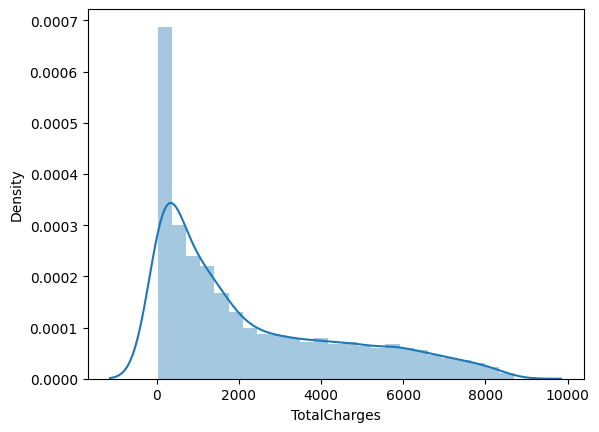

In [29]:
sns.distplot(data.TotalCharges);

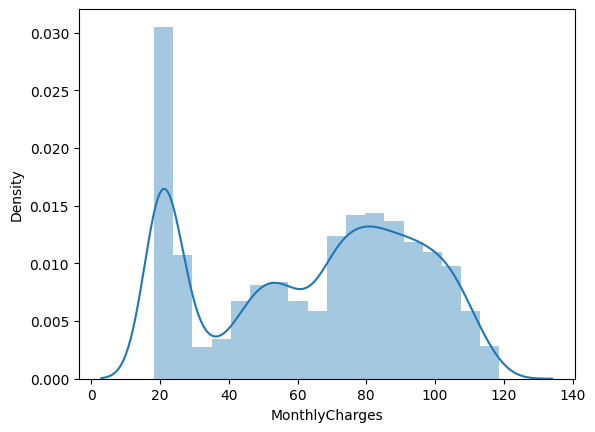

In [30]:
sns.distplot(data.MonthlyCharges);

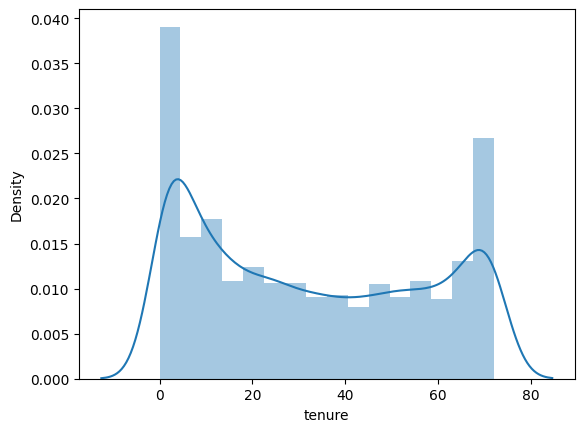

In [31]:
sns.distplot(data.tenure);

Another way of visualising outliers is using boxplots and whiskers,
which provides the quantiles (box) and inter-quantile range (whiskers),
with the outliers sitting outside the error bars (whiskers).

All the dots in the plot below are outliers according to the quantiles + 1.5 IQR rule

first let's specify the datatype of `TotalCharges` as numerical. 

In [32]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [33]:
def detect_outliers(d):
  for i in d:
    Q3, Q1 = np.percentile(data[i], [75 ,25])
    IQR = Q3 - Q1

    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR

    outliers = data[i][(data[i] > ul) | (data[i] < ll)]
    print(f'*** {i} outlier points***', '\n', outliers, '\n')

In [34]:
detect_outliers(['tenure', 'MonthlyCharges', 'TotalCharges'])

*** tenure outlier points*** 
 Series([], Name: tenure, dtype: int64) 

*** MonthlyCharges outlier points*** 
 Series([], Name: MonthlyCharges, dtype: float64) 

*** TotalCharges outlier points*** 
 Series([], Name: TotalCharges, dtype: float64) 



There is no outlier.

Categorical_Variables_Encoding

In [35]:
data['Churn'] = data['Churn'].map({'Yes':1,'No':0})

In [36]:
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

 we calculate the mean of the target for each label/category, then we order the labels according to these mean from smallest to biggest, and we number them accordingly.

Advantages:
* Capture information within the label, therefore rendering more predictive features
* Create a monotonic relationship between the variable and the target
* Does not expand the feature space

Disadvantage:
* Prone to cause over-fitting

This process should be done on the train data, then the ordered label will be mapped into test data. (since the data is large enough, ordered categories will be same if we consider the whole data or just the train set.)

In [37]:
categorical = [var for var in data.columns if data[var].dtype=='O']

In [38]:
def category(df):
    for var in categorical:
        ordered_labels = df.groupby([var])['Churn'].mean().sort_values().index

        ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
        ordinal_label
        df[var] = df[var].map(ordinal_label)

category(data)

In [39]:
data.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,0,1,1,0,0,1,2,1,2,2,2,2,2,1,3,29.85,29.85,0
1,0,0,1,1,34,1,1,1,1,2,1,2,2,2,1,0,2,56.95,1889.50,0
2,0,0,1,1,2,1,1,1,1,1,2,2,2,2,2,1,2,53.85,108.15,1
3,0,0,1,1,45,0,0,1,1,2,1,1,2,2,1,0,1,42.30,1840.75,0
4,1,0,1,1,2,1,1,2,2,2,2,2,2,2,2,1,3,70.70,151.65,1


Balance_Data

As shown in the plot above, we are dealing with an imbalanced dataset. The `BorderlineSMOTE` method is used which involves selecting those instances of the minority class that are misclassified, such as with a k-nearest neighbor classification model. This method oversamples just those difficult instances, providing more resolution only where it may be required.

In [40]:
X = data.drop(['Churn'], axis = 1)
y = data['Churn']
oversample = BorderlineSMOTE()
X, y = oversample.fit_resample(X, y)

Dataset_Splitting

let's separate the data into training and testing set.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape

((9313, 19), (1035, 19))

Feature_Scaling

In this section, numerical features are scaled.

StandardScaler = $\frac{x-\mu}{s}$

In [42]:
scaler = StandardScaler()
X_train[['TotalCharges','MonthlyCharges','tenure']] = scaler.fit_transform(X_train[['TotalCharges','MonthlyCharges','tenure']])
X_test[['TotalCharges','MonthlyCharges','tenure']] = scaler.transform(X_test[['TotalCharges','MonthlyCharges','tenure']]) 

Modeling_and_Parameter_Optimization

In [43]:
CV = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

**Model 1 : LR**

In [44]:
LR_S = LogisticRegression(random_state = 42)
params_LR = {'C': list(np.arange(1,12)), 'penalty': ['l2', 'elasticnet', 'none'], 'class_weight': ['balanced','None']}
grid_LR = RandomizedSearchCV(LR_S, param_distributions=params_LR, cv=5, n_jobs=-1, n_iter=20, random_state=42, return_train_score=True)
grid_LR.fit(X_train, y_train)
print('Best parameters:', grid_LR.best_estimator_)

Best parameters: LogisticRegression(C=1, class_weight='balanced', random_state=42)


In [45]:
LR = LogisticRegression(random_state = 42, penalty= 'l2', class_weight= 'balanced', C=6)
cross_val_LR_Acc = cross_val_score(LR, X_train, y_train, cv = CV, scoring = 'accuracy') 
cross_val_LR_f1 = cross_val_score(LR, X_train, y_train, cv = CV, scoring = 'f1')
cross_val_LR_AUC = cross_val_score(LR, X_train, y_train, cv = CV, scoring = 'roc_auc')

**Model 2: Random Forest**

In [46]:
RF_S = RandomForestClassifier(random_state = 42)
params_RF = {'n_estimators': list(range(50,100)), 'min_samples_leaf': list(range(1,5)), 'min_samples_split': list(range(1,5))}
grid_RF = RandomizedSearchCV(RF_S, param_distributions=params_RF, cv=5, n_jobs=-1, n_iter=20, random_state=42, return_train_score=True)
grid_RF.fit(X_train, y_train)
print('Best parameters:', grid_RF.best_estimator_)

Best parameters: RandomForestClassifier(n_estimators=66, random_state=42)


In [47]:
RF = RandomForestClassifier(n_estimators=70, random_state=42)
cross_val_RF_Acc = cross_val_score(RF, X_train, y_train, cv = CV, scoring = 'accuracy') 
cross_val_RF_f1 = cross_val_score(RF, X_train, y_train, cv = CV, scoring = 'f1')
cross_val_RF_AUC = cross_val_score(RF, X_train, y_train, cv = CV, scoring = 'roc_auc')

**Model 3: KNN**

In [48]:
KNN_S = KNeighborsClassifier()
params_KNN = {'n_neighbors': list(range(1,20))}
grid_KNN = RandomizedSearchCV(KNN_S, param_distributions=params_KNN, cv=5, n_jobs=-1, n_iter=20, random_state=42, return_train_score=True)
grid_KNN.fit(X_train, y_train)
print('Best parameters:', grid_KNN.best_estimator_)

Best parameters: KNeighborsClassifier(n_neighbors=16)


In [49]:
KNN = KNeighborsClassifier(n_neighbors=1)
cross_val_KNN_Acc = cross_val_score(KNN, X_train, y_train, cv = CV, scoring = 'accuracy') 
cross_val_KNN_f1 = cross_val_score(KNN, X_train, y_train, cv = CV, scoring = 'f1')
cross_val_KNN_AUC = cross_val_score(KNN, X_train, y_train, cv = CV, scoring = 'roc_auc')

**Model 4: Decision Tree**

In [50]:
DT_S = DecisionTreeClassifier(random_state=42)
params_DT = {'min_samples_leaf': list(range(1,6)), 'min_samples_split': list(range(1,6))}
grid_DT = RandomizedSearchCV(DT_S, param_distributions=params_DT, cv=5, n_jobs=-1, n_iter=20, random_state=42, return_train_score=True)
grid_DT.fit(X_train, y_train)
print('Best parameters:', grid_DT.best_estimator_)

Best parameters: DecisionTreeClassifier(random_state=42)


In [51]:
DT = DecisionTreeClassifier(random_state=42)
cross_val_DT_Acc = cross_val_score(DT, X_train, y_train, cv = CV, scoring = 'accuracy') 
cross_val_DT_f1 = cross_val_score(DT, X_train, y_train, cv = CV, scoring = 'f1')
cross_val_DT_AUC = cross_val_score(DT, X_train, y_train, cv = CV, scoring = 'roc_auc')

**Model 5: Ada Boost**

In [52]:
AB_S = AdaBoostClassifier(random_state=42)
params_AB = {'n_estimators': list(np.arange(50,100,10)), 'learning_rate':[0.01, 0.1, 1]}
grid_AB = RandomizedSearchCV(AB_S, param_distributions=params_AB, cv=5, n_jobs=-1, n_iter=20, random_state=42, return_train_score=True)
grid_AB.fit(X_train, y_train)
print('Best parameters:', grid_AB.best_estimator_)

Best parameters: AdaBoostClassifier(learning_rate=1, n_estimators=90, random_state=42)


In [53]:
AB = AdaBoostClassifier(learning_rate=1, n_estimators=90, random_state=42)
cross_val_AB_Acc = cross_val_score(AB, X_train, y_train, cv = CV, scoring = 'accuracy') 
cross_val_AB_f1 = cross_val_score(AB, X_train, y_train, cv = CV, scoring = 'f1')
cross_val_AB_AUC = cross_val_score(AB, X_train, y_train, cv = CV, scoring = 'roc_auc')

**Model 6: XG Boost**

In [54]:
XG_S = XGBClassifier(random_state=42)
params_XG = {'n_estimators': list(np.arange(50,150,10)), 'learning_rate':[0.01, 0.1, 1]}
grid_XG = RandomizedSearchCV(XG_S, param_distributions=params_XG, cv=5, n_jobs=-1, n_iter=20, random_state=42, return_train_score=True)
grid_XG.fit(X_train, y_train)
print('Best parameters:', grid_XG.best_estimator_)

Best parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=120, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


In [55]:
XG = XGBClassifier(learning_rate=1, n_estimators=120, random_state=42)
cross_val_XG_Acc = cross_val_score(XG, X_train, y_train, cv = CV, scoring = 'accuracy') 
cross_val_XG_f1 = cross_val_score(XG, X_train, y_train, cv = CV, scoring = 'f1')
cross_val_XG_AUC = cross_val_score(XG, X_train, y_train, cv = CV, scoring = 'roc_auc')

Feature_Importance

What features contribute more to predict the target (Churn)? let's find out how useful they are at predicting the target variable.

Random Forest algorithm offer importance scores based on the reduction in the criterion used to select split points, like Gini or entropy.

In [56]:
RF_I = RandomForestClassifier(n_estimators=70, random_state=42)
RF_I.fit(X, y)

RandomForestClassifier(n_estimators=70, random_state=42)

In [57]:
d = {'Features': X_train.columns, 'Feature Importance': RF_I.feature_importances_}
df = pd.DataFrame(d)
df_sorted = df.sort_values(by='Feature Importance', ascending = True)
df_sorted
df_sorted.style.background_gradient(cmap='Blues')

,Features,Feature Importance
5,PhoneService,0.007307
1,SeniorCitizen,0.014736
3,Dependents,0.018383
15,PaperlessBilling,0.022416
2,Partner,0.022599
6,MultipleLines,0.023853
8,OnlineSecurity,0.024549
10,DeviceProtection,0.025111
9,OnlineBackup,0.027230
12,StreamingTV,0.027710


Results

In [58]:
compare_models = [('Logistic Regression', cross_val_LR_Acc.mean(),cross_val_LR_f1.mean(),cross_val_LR_AUC.mean(), ''),
                  ('Random Forest', cross_val_RF_Acc.mean(),cross_val_RF_f1.mean(),cross_val_RF_AUC.mean(), ''),
                  ('KNN', cross_val_KNN_Acc.mean(),cross_val_KNN_f1.mean(),cross_val_KNN_AUC.mean(), ''),
                  ('Decision Tree', cross_val_DT_Acc.mean(), cross_val_DT_f1.mean(),cross_val_DT_AUC.mean(), ''),
                  ('Ada Boost', cross_val_AB_Acc.mean(), cross_val_AB_f1.mean(),cross_val_AB_AUC.mean(), ''),
                  ('XG Boost', cross_val_XG_Acc.mean(), cross_val_XG_f1.mean(),cross_val_XG_AUC.mean(), '')]


In [59]:
compare = pd.DataFrame(data = compare_models, columns=['Model','Accuracy Mean', 'F1 Score Mean', 'AUC Score Mean', 'Description'])
compare.style.background_gradient(cmap='YlGn')

,Model,Accuracy Mean,F1 Score Mean,AUC Score Mean,Description
0,Logistic Regression,0.745517,0.757981,0.826560,
1,Random Forest,0.833889,0.839960,0.912989,
2,KNN,0.769894,0.782321,0.770055,
3,Decision Tree,0.771718,0.774108,0.772792,
4,Ada Boost,0.768064,0.779442,0.845977,
5,XG Boost,0.821433,0.825238,0.901602,


Random Forest model is the most stable and accurate model. As a result,Random Forest is selected for the purpose of predicting Churn.

In [60]:
RF_I.fit(X_train, y_train)
y_pred = RF_I.predict(X_test)

In [61]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       505
           1       0.82      0.88      0.85       530

    accuracy                           0.84      1035
   macro avg       0.84      0.84      0.84      1035
weighted avg       0.84      0.84      0.84      1035



In [62]:
y_prob = RF_I.predict_proba(X_test)
roc_auc_score(y_test, y_prob[:,1],average='macro')

0.9221109658135624

In [63]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype(int)


In [64]:
cm

array([[404, 101],
       [ 62, 468]])

We achieved about $84\%$ accuracy on the test.  

Customer churn is definitely bad to a firm ’s profitability. Various strategies can be implemented to eliminate customer churn. The best way to avoid customer churn is for a company to truly know its customers. This includes identifying customers who are at risk of churning and working to improve their satisfaction. Improving customer service is, of course, at the top of the priority for tackling this issue. Building customer loyalty through relevant experiences and specialized service is another strategy to reduce customer churn. Some firms survey customers who have already churned to understand their reasons for leaving in order to adopt a proactive approach to avoiding future customer churn.

In [65]:
import pickle
# Train a  model and save its parameters to a pickle file
model = RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)
model.fit(X_test, y_test)
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)


# Load the object from the file
with open('model.pkl', 'rb') as f:
    model= pickle.load(f)

In [66]:
y_prob = model.predict_proba(X_test)
roc_auc_score(y_test, y_prob[:,1],average='macro')

0.8927479917803101